## **Alzheimer's Disease Prediction**

### Read the Data

In [1]:
!pip install tensorflow catboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("/content/alzheimers_disease_data.csv")
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

### Exploratory Data Analysis

In [4]:
print("Dataset Information:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   

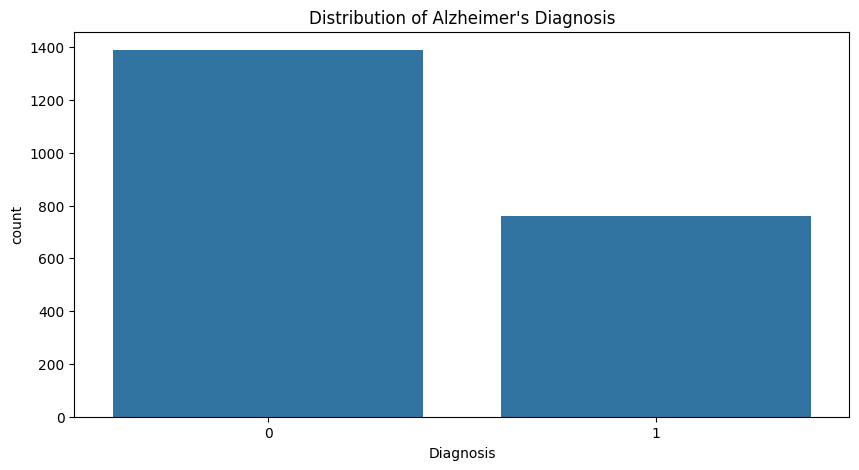

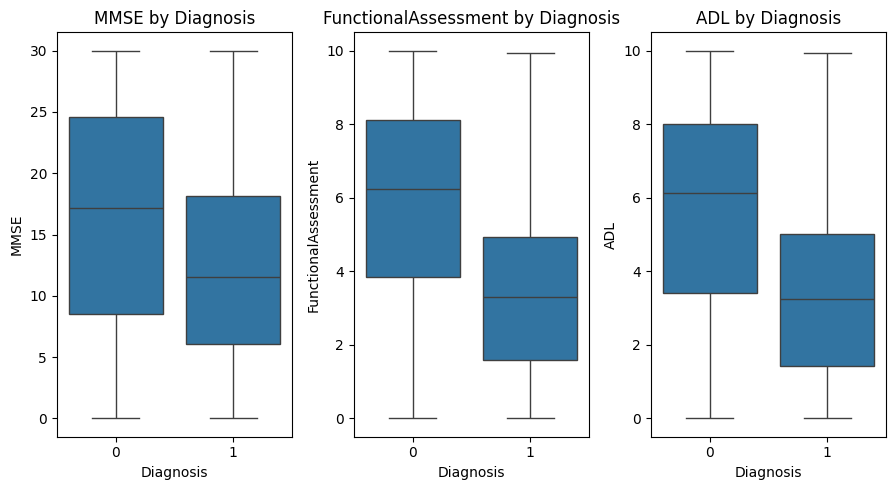

In [5]:
# Plot distribution of Alzheimer's Diagnosis and Cognitive and Functional Assessments Scores
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Diagnosis')
plt.title('Distribution of Alzheimer\'s Diagnosis')
plt.show()

medical_features = ['MMSE', 'FunctionalAssessment', 'ADL']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(medical_features):
    plt.subplot(1, 5, i+1)
    sns.boxplot(data=data, x='Diagnosis', y=feature)
    plt.title(f'{feature} by Diagnosis')
plt.tight_layout()
plt.show()

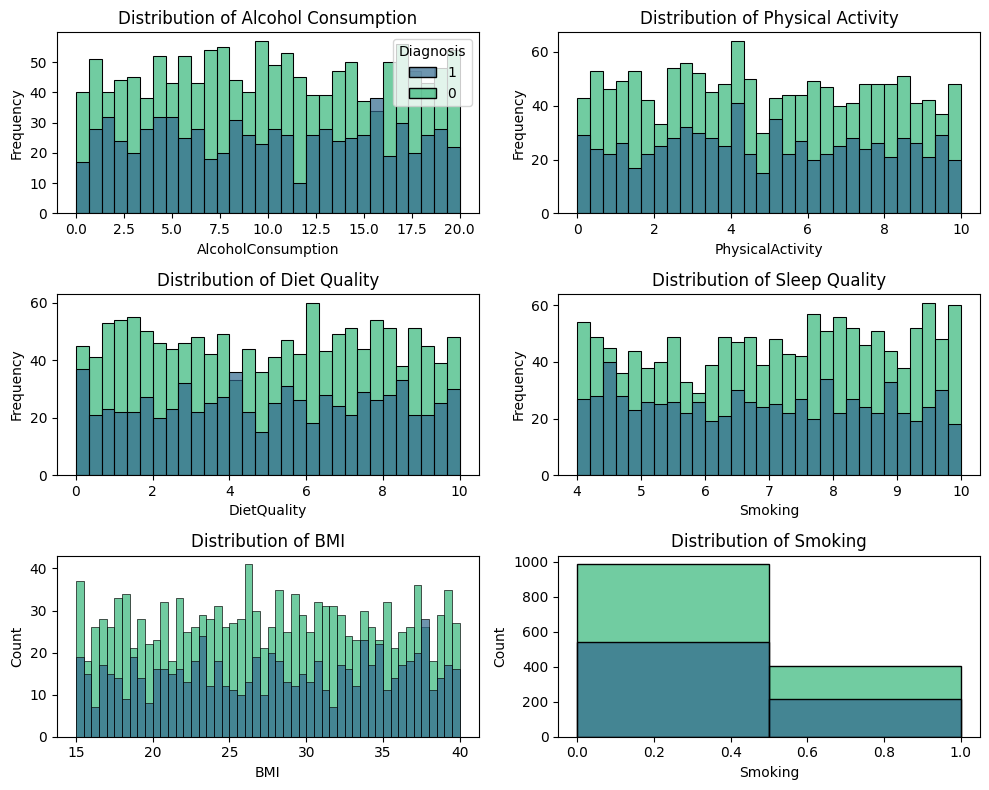

In [6]:
# plot distribution of Lifestyle Factors based on Diagnosis
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

hue_order = [1, 0]

sns.histplot(ax=axes[0, 0], x='AlcoholConsumption', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', alpha=.7).set(title='Distribution of Alcohol Consumption')
axes[0, 0].set_xlabel('AlcoholConsumption')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[0, 1], x='PhysicalActivity', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Physical Activity')
axes[0, 1].set_xlabel('PhysicalActivity')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 0], x='DietQuality', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Diet Quality')
axes[1, 0].set_xlabel('DietQuality')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 1], x='SleepQuality', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Sleep Quality')
axes[1, 1].set_xlabel('SleepQuality')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[2, 0], x='BMI', data=data, hue='Diagnosis', hue_order=hue_order, bins=50, palette='viridis', legend=False, alpha=.7).set(title='Distribution of BMI')
axes[1, 1].set_xlabel('BMI')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[2, 1], x='Smoking', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Smoking')
axes[1, 1].set_xlabel('Smoking')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

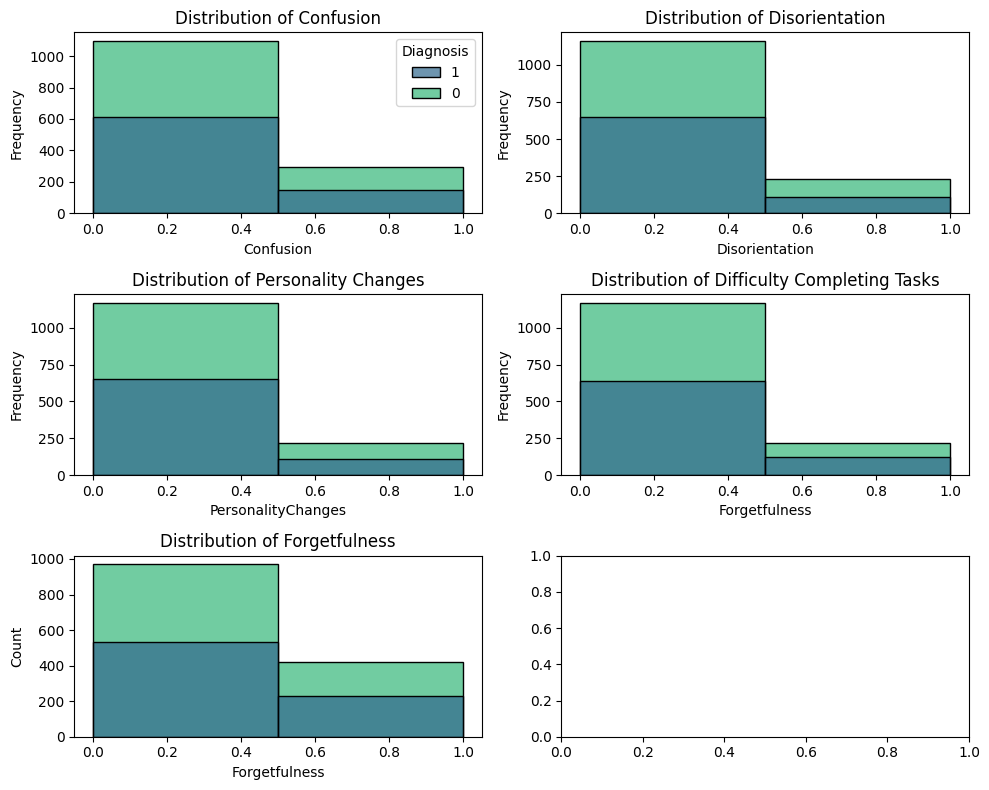

In [7]:
# Plot distribution of symptoms based on Diagnosis
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

hue_order = [1, 0]

sns.histplot(ax=axes[0, 0], x='Confusion', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', alpha=.7).set(title='Distribution of Confusion')
axes[0, 0].set_xlabel('Confusion')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[0, 1], x='Disorientation', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Disorientation')
axes[0, 1].set_xlabel('Disorientation')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 0], x='PersonalityChanges', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Personality Changes')
axes[1, 0].set_xlabel('PersonalityChanges')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 1], x='DifficultyCompletingTasks', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Difficulty Completing Tasks')
axes[1, 1].set_xlabel('DifficultyCompletingTasks')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[2, 0], x='Forgetfulness', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Forgetfulness')
axes[1, 1].set_xlabel('Forgetfulness')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

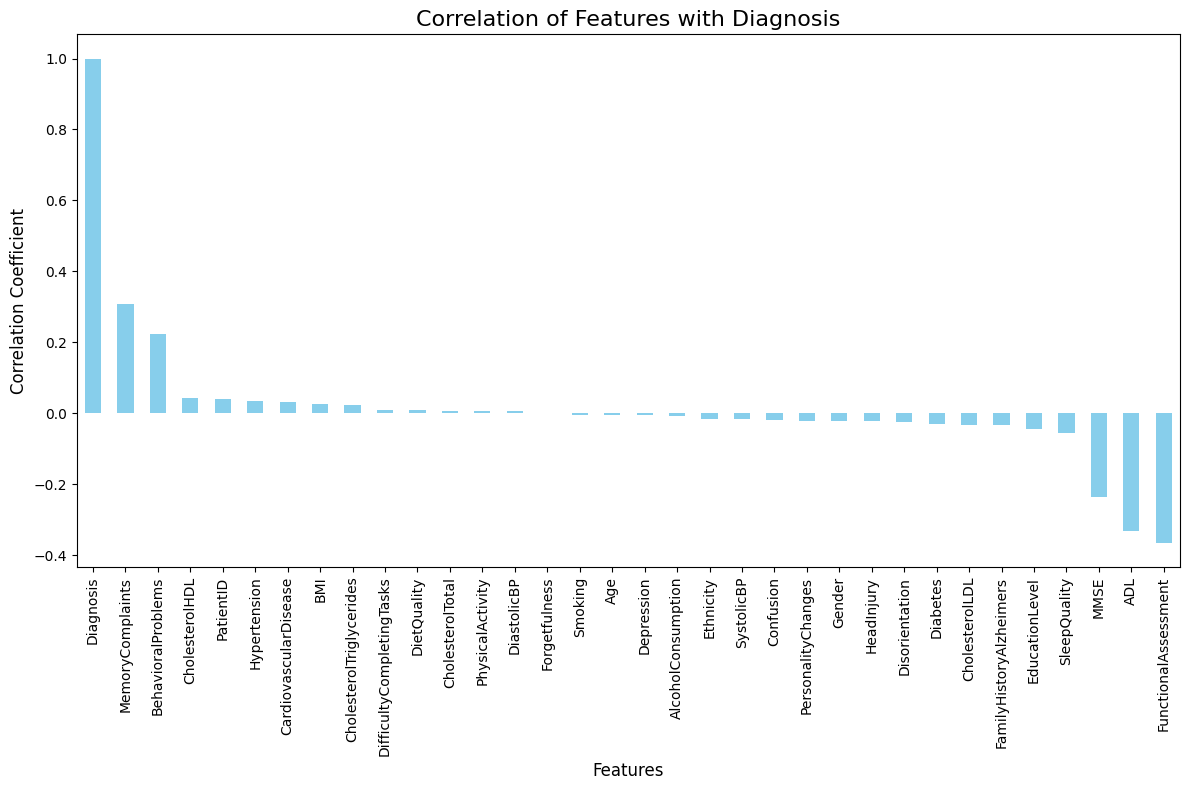

In [8]:
# Find correlation of variables with diagnosis
numeric_data = data.select_dtypes(include=["number"])

corr_diagnosis = numeric_data.corr()['Diagnosis'].sort_values(ascending=False)

# plot the correlation of features with 'Diagnosis'
plt.figure(figsize=(12, 8))
corr_diagnosis.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with Diagnosis", fontsize=16)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

The chart confirms what we already know about how Alzheimer's affects Cognitive and Functional Assessments. Alzheimer's Diagnosis is positively correlated to existence of Memory Complaints and Behavioral Problems, while negatively correlated to Functional Assessment, Activities of Daily Living, and Mini-Mental State Examination scores.

Surprisingly, it is showing that Alzheimer's Diagnosis isn't highly correlated with Age and most Lifestyle Factors (i.e. BMI, Diet Quality, and Physical Activity).

Another thing to note is that the diagnosis also shows lower correlation with the symptoms such as Confusion and Disorientation.

In [9]:
# check for multicollinearity with VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = numeric_data.drop(columns=['Diagnosis'])

X_with_constant = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_constant.values, i + 1) for i in range(X.shape[1])]

print(vif_data)

                      Feature       VIF
0                   PatientID  1.011579
1                         Age  1.016994
2                      Gender  1.012811
3                   Ethnicity  1.010912
4              EducationLevel  1.017643
5                         BMI  1.017375
6                     Smoking  1.014539
7          AlcoholConsumption  1.009179
8            PhysicalActivity  1.009126
9                 DietQuality  1.015051
10               SleepQuality  1.015419
11    FamilyHistoryAlzheimers  1.011197
12      CardiovascularDisease  1.013989
13                   Diabetes  1.014428
14                 Depression  1.010561
15                 HeadInjury  1.014549
16               Hypertension  1.015086
17                 SystolicBP  1.009060
18                DiastolicBP  1.009631
19           CholesterolTotal  1.011760
20             CholesterolLDL  1.013189
21             CholesterolHDL  1.012858
22   CholesterolTriglycerides  1.014855
23                       MMSE  1.009076


There's no significant multicollinearity between the vairables

# Feature Engineering

In [10]:
#drop columns
data = data.drop(['PatientID', 'DoctorInCharge'], axis=1)

In [11]:
# one-hot encoding
categorical_cols = ['Ethnicity', 'EducationLevel']
data = pd.get_dummies(data, columns=categorical_cols)

In [12]:
# Split features and target
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Feature selection
selector = SelectFromModel(
    XGBClassifier(n_estimators=100, random_state=42),
    threshold='median'
)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]


# Modeling

In [13]:
# data split
# 60% train, 20% validation, 20% test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


# scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# callback setting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

In [14]:
# model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),
          input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])



model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# train NN
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4618 - loss: 2.7847 - val_accuracy: 0.4349 - val_loss: 2.5006 - learning_rate: 5.0000e-04
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4942 - loss: 2.6786 - val_accuracy: 0.4349 - val_loss: 2.4730 - learning_rate: 5.0000e-04
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5283 - loss: 2.5586 - val_accuracy: 0.4186 - val_loss: 2.4420 - learning_rate: 5.0000e-04
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5701 - loss: 2.4858 - val_accuracy: 0.4512 - val_loss: 2.4054 - learning_rate: 5.0000e-04
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5884 - loss: 2.4216 - val_accuracy: 0.4791 - val_loss: 2.3666 - learning_rate: 5.0000e-04
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6107 - loss: 2.3321 - val_accuracy: 0.5465 - val_loss: 2.3206 - learning_rate: 5.0000e-04
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6412

In [15]:
# model
models = {
    'xgb': XGBClassifier(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=4,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'lgbm': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=4,
        num_leaves=15,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'catboost': CatBoostClassifier(
        iterations=200,
        learning_rate=0.01,
        depth=4,
        subsample=0.8,
        random_state=42,
        verbose=False
    )
}

# model training
val_predictions = {}
test_predictions = {}
for name, model_instance in models.items():
    print(f"Training {name}...")
    model_instance.fit(X_train_scaled, y_train)
    val_predictions[name] = model_instance.predict_proba(X_val_scaled)[:, 1]
    test_predictions[name] = model_instance.predict_proba(X_test_scaled)[:, 1]

Training xgb...
Training lgbm...
[LightGBM] [Info] Number of positive: 456, number of negative: 833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 1289, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353763 -> initscore=-0.602541
[LightGBM] [Info] Start training from score -0.602541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [16]:
# deep learning
val_predictions['deep'] = model.predict(X_val_scaled).ravel()
test_predictions['deep'] = model.predict(X_test_scaled).ravel()

# ensemble
weights = {'deep': 0.3, 'xgb': 0.3, 'lgbm': 0.2, 'catboost': 0.2}
val_ensemble_pred = sum(pred * weights[name] for name, pred in val_predictions.items())
test_ensemble_pred = sum(pred * weights[name] for name, pred in test_predictions.items())

val_pred_binary = (val_ensemble_pred > 0.5).astype(int)
test_pred_binary = (test_ensemble_pred > 0.5).astype(int)

# model eval on validation set
print("\n=== Validation Set Performance ===")
for name, pred in val_predictions.items():
    pred_binary = (pred > 0.5).astype(int)
    acc = accuracy_score(y_val, pred_binary)
    auc = roc_auc_score(y_val, pred)
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")

print(f"\nEnsemble (Validation):")
print(f"Accuracy: {accuracy_score(y_val, val_pred_binary):.4f}")
print(f"AUC: {roc_auc_score(y_val, val_ensemble_pred):.4f}")

# Model eval on test set
print("\n=== Test Set Performance ===")
for name, pred in test_predictions.items():
    pred_binary = (pred > 0.5).astype(int)
    acc = accuracy_score(y_test, pred_binary)
    auc = roc_auc_score(y_test, pred)
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")

print(f"\nEnsemble (Test):")
print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
print(f"AUC: {roc_auc_score(y_test, test_ensemble_pred):.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Validation Set Performance ===

xgb:
Accuracy: 0.9488
AUC: 0.9594

lgbm:
Accuracy: 0.9558
AUC: 0.9588

catboost:
Accuracy: 0.9581
AUC: 0.9547

deep:
Accuracy: 0.8744
AUC: 0.9300

Ensemble (Validation):
Accuracy: 0.9395
AUC: 0.9563

=== Test Set Performance ===

xgb:
Accuracy: 0.9535
AUC: 0.9447

lgbm:
Accuracy: 0.9558
AUC: 0.9459

catboost:
Accuracy: 0.9535
AUC: 0.9480

deep:
Accuracy: 0.8860
AUC: 0.9220

Ensemble (Test):
Accuracy: 0.9465
AUC: 0.9474


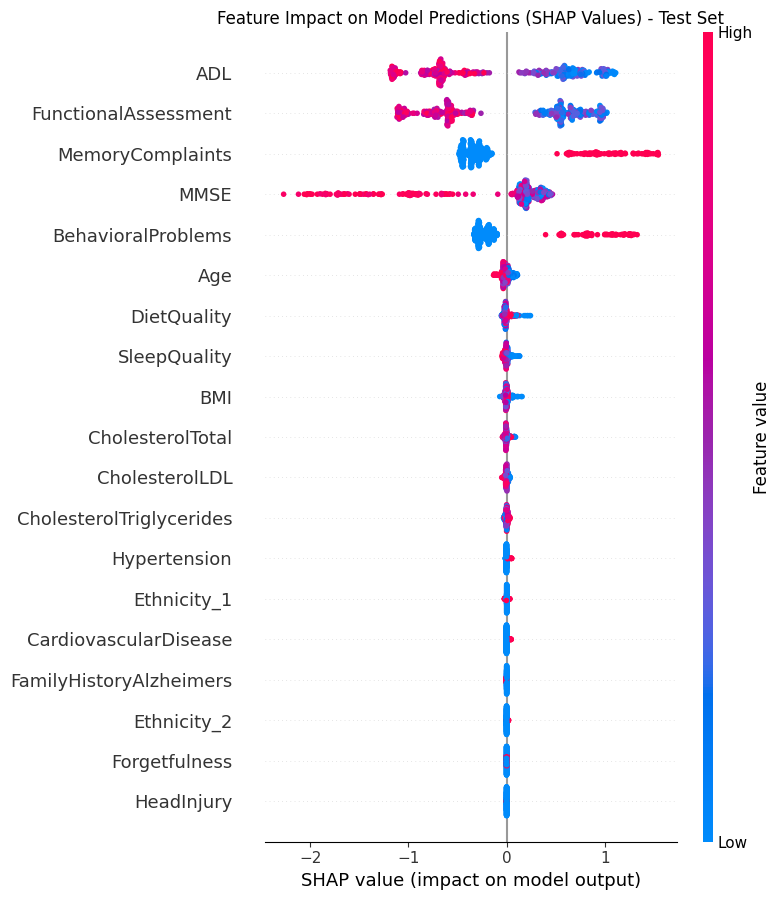

In [21]:
# model interpretability
# SHAP values
explainer = shap.TreeExplainer(models['xgb'])
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title('Feature Impact on Model Predictions (SHAP Values) - Test Set')
plt.tight_layout()
plt.show()


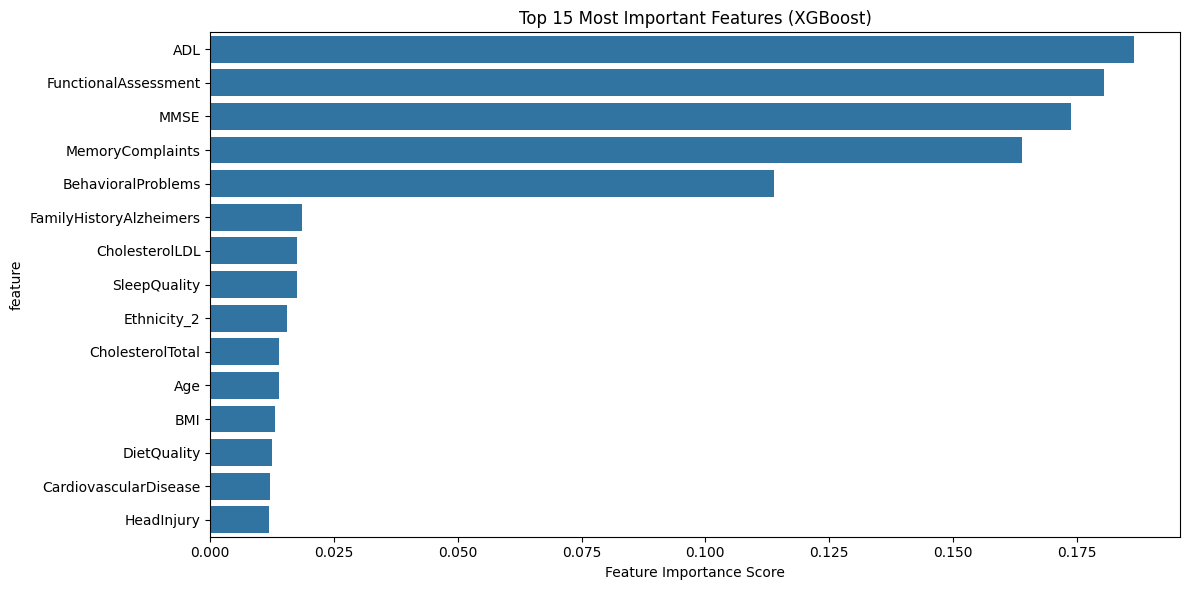

In [22]:
# feature importance plot
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models['xgb'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

In [23]:
# individual prediction explanation function
def explain_prediction(patient_data, model, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'impact': np.abs(shap_values[0])
    }).sort_values('impact', ascending=False).head(5)

    return feature_importance

In [24]:
# example test patient prediction explanation
sample_patient = X_test_scaled[0:1]
explanation = explain_prediction(sample_patient, models['xgb'], X.columns)
print("\nTest Patient Prediction Explanation:")
print("Top 5 Contributing Features:")
print(explanation)


Test Patient Prediction Explanation:
Top 5 Contributing Features:
                 feature    impact
15                   ADL  1.014910
12  FunctionalAssessment  0.978716
11                  MMSE  0.357287
13      MemoryComplaints  0.282560
14    BehavioralProblems  0.183131


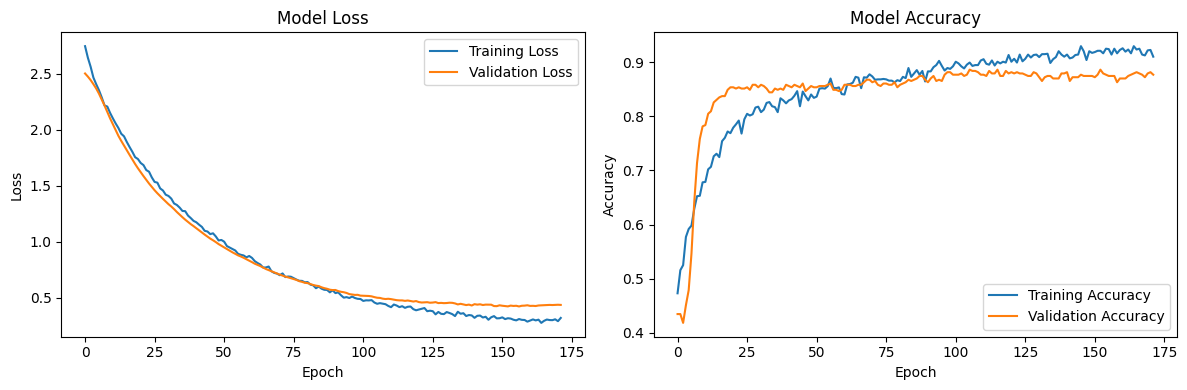

In [25]:
# learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

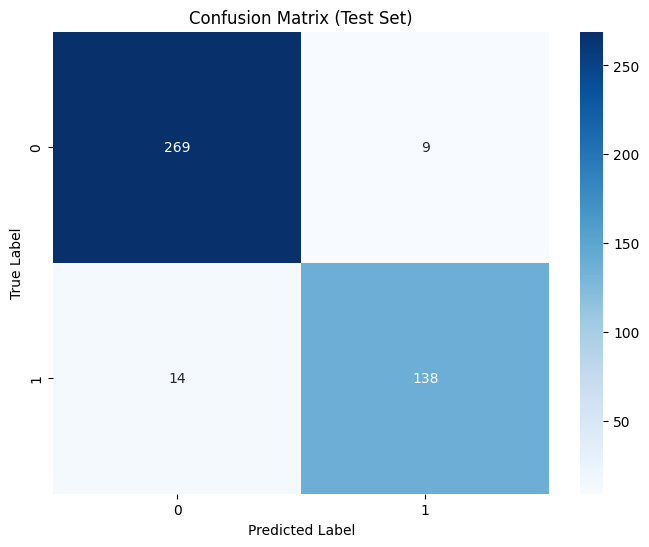

In [26]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, test_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
